# Klasifikasi _American Sign Language_ (ASL) dengan _Oriented FAST and Rotated BRIEF_ (ORB) dan _Support Vector Machine_ (SVM)

Anggota Kelompok:
1. Kaisar Kertarajasa (1301213276)
2. Adrian Aditya Prathama (1301213448)

## Inisiasi Data

Dataset diperoleh melalui Kaggle pada tautan https://www.kaggle.com/datasets/grassknoted/asl-alphabet.

Dataset tersebut berisi citra bahasa isyarat Amerika (_American Sign Language_) berdimensi $200 \times 200$ piksel yang terbagi ke dalam 29 kelas, yakni 26 alfabet latin dari A sampai Z, ditambah dengan kelas `del`, `nothing`, dan `space`.

Segmen ini berfokus pada pembacaan data citra digital dan membagi data ke dalam data latih dan data uji.
Sebanyak 20% data akan dimanfaatkan sebagai data uji, sisanya adalah data latih.

In [1]:
# Pertama, impor library yang dibutuhkan untuk pengolahan data

import gc # library garbage collection, untuk menghapus variabel dan membebaskannya dari memori. Hal ini bertujuan untuk menghemat penggunaan memori dari data yang tidak diperlukan lagi
import os # library fungsionalitas tingkat OS, terutama saat bekerja dengan direktori dataset
import cv2 as cv # library pemrosesan citra
import numpy as np # untuk pengolahan data numerik

# Dua library di bawah ini berguna untuk visualisasi data
import matplotlib.pyplot as plt 
import seaborn as sns

from random import shuffle # fungsi shuffle untuk mengocok data sebelum dipisahkan ke data latih dan data uji
from sklearn.model_selection import train_test_split # memisahkan data ke dalam data latih dan data uji

In [2]:
# Program dijalankan secara lokal pada mesin
# Mendefinisikan lokasi dataset pada penyimpanan lokal (folder dataset berada pada direktori yang sama dengan file .ipynb ini)

train_folder_dir = 'asl-alphabet/asl_alphabet_train/asl_alphabet_train'
train_folder_contents = os.listdir(train_folder_dir) 
print(f'Isi folder {train_folder_dir}:')
print(train_folder_contents) # Folder untuk setiap kelas. Berisi citra 200 x 200 piksel dari bahasa isyarat (ASL). Total: 29 Folder.

print()

test_folder_dir = 'asl-alphabet/asl_alphabet_test/asl_alphabet_test'
test_folder_contents = os.listdir(test_folder_dir) 
print(f'Isi folder {test_folder_dir}:')
print(test_folder_contents) # Hanya ada satu citra untuk setiap kelas. Pengujian membutuhkan lebih banyak citra. Kelas 'del' absen.

# Oleh karena itu, kita tidak menggunakan 'asl-alphabet/asl_alphabet_test/asl_alphabet_test'
# Kita akan menggunakan 'asl-alphabet/asl_alphabet_train/asl_alphabet_train',
# dengan split dataset untuk pelatihan dan pengujian

Isi folder asl-alphabet/asl_alphabet_train/asl_alphabet_train:
['W', 'V', 'G', 'D', 'P', 'A', 'J', 'C', 'F', 'U', 'del', 'space', 'B', 'N', 'L', 'R', 'H', 'O', 'X', 'I', 'M', 'Q', 'S', 'Z', 'K', 'nothing', 'Y', 'E', 'T']

Isi folder asl-alphabet/asl_alphabet_test/asl_alphabet_test:
['Y_test.jpg', 'space_test.jpg', 'O_test.jpg', 'Q_test.jpg', 'V_test.jpg', 'W_test.jpg', 'B_test.jpg', 'T_test.jpg', 'U_test.jpg', 'nothing_test.jpg', 'R_test.jpg', 'H_test.jpg', 'K_test.jpg', 'G_test.jpg', 'L_test.jpg', 'M_test.jpg', 'F_test.jpg', 'Z_test.jpg', 'X_test.jpg', 'A_test.jpg', 'C_test.jpg', 'I_test.jpg', 'E_test.jpg', 'J_test.jpg', 'S_test.jpg', 'P_test.jpg', 'D_test.jpg', 'N_test.jpg']


In [3]:
# Mendefinisikan direktori dataset
DATADIR = 'asl-alphabet/asl_alphabet_train/asl_alphabet_train'

In [4]:
# Daftar setiap kelas

CLASSES = sorted(os.listdir(DATADIR))
print(f"Banyaknya kelas: {len(CLASSES)}")
print(f"Daftar kelas: \n{CLASSES}")

Banyaknya kelas: 29
Daftar kelas: 
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [5]:
# Mendefinisikan fungsi untuk membaca citra (secara default, citra akan dibaca dalam grayscale)
# Ukuran default citra hasil pembacaan adalah 200 x 200 piksel

def readimg(filename,
            grayscale = True,
            imsize = (200, 200)
           ):
    im = cv.imread(filename)
    im = cv.resize(im, imsize)
    if grayscale:
        im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    return im

In [6]:
# Inisiasi dataset

# Inisiasi array untuk data latih 
train_images = [] # Citra
y_train = [] # Label

# Inisiasi array untuk data uji 
test_images = [] # Data
y_test = [] # Label

# Pengulangan:
# 1. Mengambil citra secara acak dari setiap kelas, dengan jumlah yang sudah ditentukan sebelumnya
# 2. Membagi data citra per kelas menjadi data latih dan data uji
# 3. Menggabungkan hasil pembacaan masing-masing citra, untuk data latih dan data uji.

for i in range(len(CLASSES)):
    classdir = os.path.join(DATADIR, CLASSES[i]) # Direktori masing-masing kelas (folder yang berisi citra untuk satu kelas)
    
    lf = os.listdir(classdir) # List file citra untuk setiap kelas
    shuffle(lf)        # Mengacak isi list
    
    files = [os.path.join(classdir, x) for x in lf] # Menghasilkan direktori lengkap dan jelas untuk setiap file citra yang digunakan agar dapat dibaca
    train_images_class_all = [readimg(x) for x in files]       # Membaca citra untuk setiap file
    y_class_all = [i] * len(files)                  # Label setiap citra akan seragam, karena setiap iterasi akan membaca citra untuk satu kelas.

    # Train-test split. Membagi data satu kelas ke data latih dan data uji. Besarnya persentase data uji telah ditentukan sebelumnya
    train_images_class, test_images_class, y_train_class, y_test_class = train_test_split(train_images_class_all, y_class_all, test_size=0.2)
    
    # Menyatukan data latih dan data uji dari masing-masing kelas menjadi satu
    train_images += train_images_class
    y_train += y_train_class
    test_images += test_images_class
    y_test += y_test_class

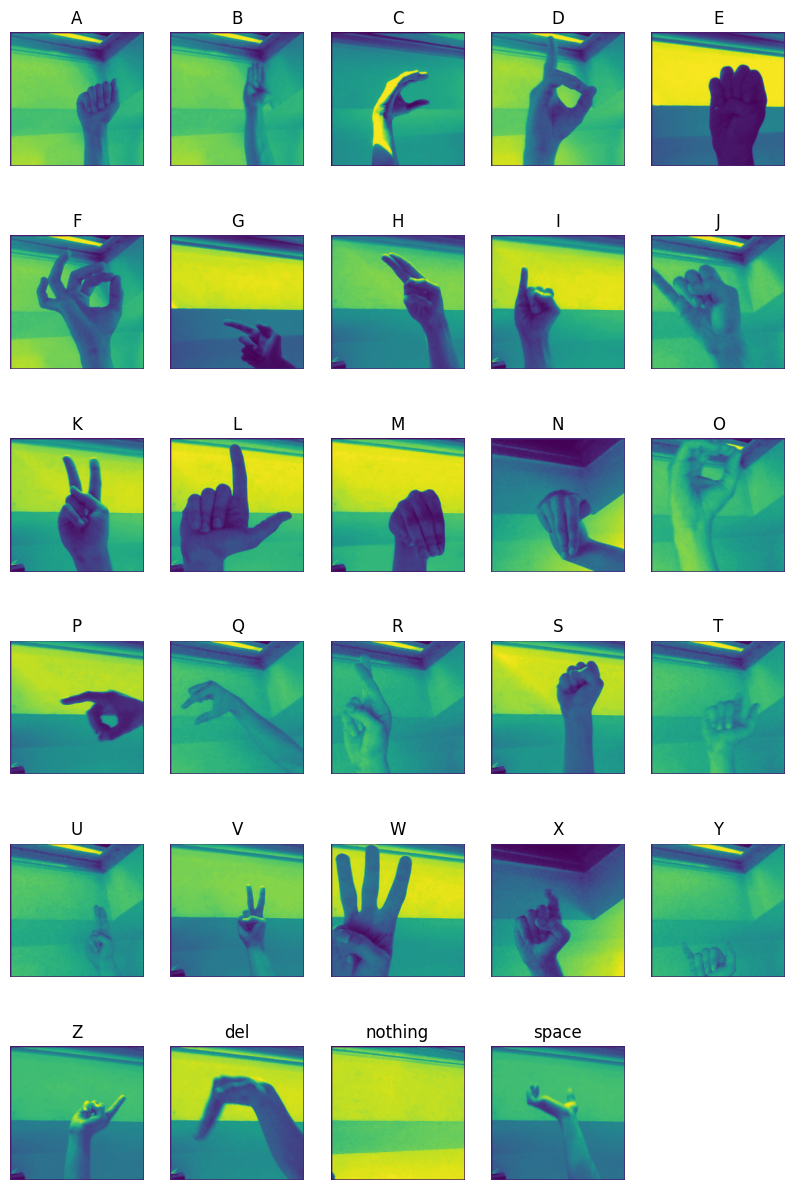

In [7]:
# Memvisualisasikan gambar untuk masing-masing kelas pada dataset latih
# Catatan: citra pada array dataset latih telah disortir menurut kelasnya

plt.figure(figsize=(10, 18))
for i in range(len(CLASSES)):
    ax = plt.subplot(7, 5, i+1)
    im = train_images[(len(train_images) // 29) * i] # Agar terambil citra pertama dari setiap kelas yang ada
    plt.imshow(im)
    plt.title(CLASSES[i])
    plt.axis('off')

## Pemrosesan Citra: _Image Enhancement_

_Image enhancement_ dilakukan untuk meningkatkan kualitas citra. 
Pada eksperimen ini, _image enhancement_ bertujuan untuk membersihkan citra dari noise dan meningkatkan kontras citra 
agar proses ekstraksi fitur dengan ORB dapat berjalan dengan baik.

In [8]:
# Fungsi untuk meningkatkan kualitas citra

def enhance(img):
    img = cv.equalizeHist(img)  # Ekualisasi histogram, meningkatkan kontras pada citra
    img = cv.medianBlur(img, 3) # Menghilangkan noise dari citra dengan median filter
    img = cv.medianBlur(img, 3)

    return img

In [9]:
# Mengaplikasikan fungsi enhance() terhadap data citra

train_images_enhanced = [enhance(im) for im in train_images]
test_images_enhanced = [enhance(im) for im in test_images]


# Menghapus data citra mentah yang belum diolah dari memori, untuk menghemat penggunaan ruang pada memori

del train_images
del test_images
gc.collect()

63

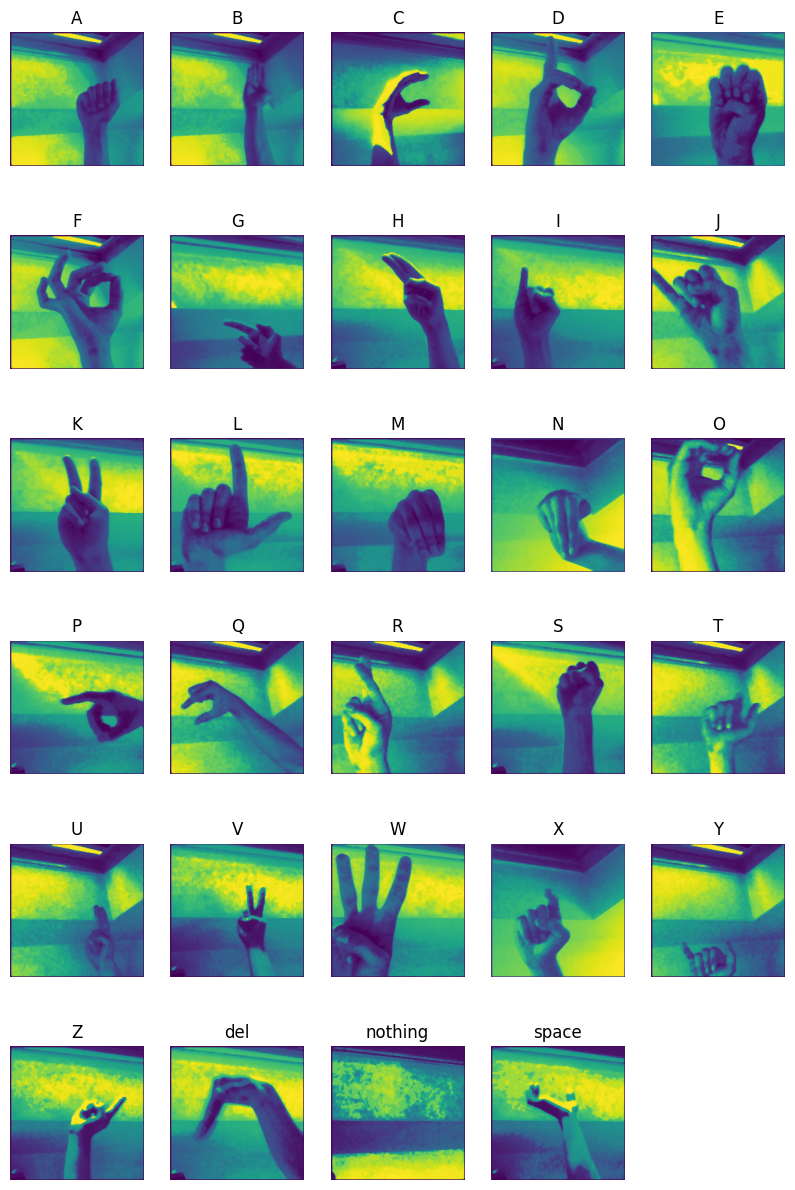

In [10]:
# Memvisualisasikan citra hasil pengolahan
# Catatan: citra pada array dataset latih telah disortir menurut kelasnya

plt.figure(figsize=(10, 18))
for i in range(len(CLASSES)):
    ax = plt.subplot(7, 5, i+1)
    im = train_images_enhanced[(len(train_images_enhanced) // 29) * i] # Agar terambil citra pertama dari setiap kelas yang ada
    plt.imshow(im)
    plt.title(CLASSES[i])
    plt.axis('off')

## Pemrosesan Citra: Ekstraksi Ciri

Teknik ekstraksi ciri yang akan digunakan pada eksperimen ini adalah _Oriented FAST and Rotated BRIEF_ (ORB).
Pemilihan teknik ini didasari dengan kelebihan ORB dari segi kecepatan dan efisiensi.

In [11]:
# Inisiasi ekstraksi ciri

orb = cv.ORB_create()

# Fungsi untuk mengekstrak deskriptor ciri (feature descriptor) dari sebuah citra
def get_featuredesc_ORB(im):
    # Pertama, mengambil keypoint dari citra
    kp = orb.detect(im, None)

    # Setelah itu, mendapatkan desciptor berdasarkan keypoint yang ada
    kp, des = orb.compute(im, kp)

    # Terdapat kemungkinan bahwa tidak ada keypoint maupun descriptor yang ditangkap, sehingga des dapat bernilai None.
    # Karena itu, agar fungsi tidak mengembalikan None, jika des bernilai None maka fungsi akan mengembalikan array berisi nol dengan
    # dimensi (1, 32)
    return des if des is not None else np.zeros((1,32))


# Fungsi yang mengembalikan visualisasi keypoint untuk fitur-fitur pada sebuah citra
def get_keypoint_vis_ORB(im):
    kp = orb.detect(im, None)

    # Visualisasi keypoint ke dalam citra menggunakan fungsi cv.drawKeypoints()
    # Sekali lagi, hal ini akan berlaku hanya jika keypoints terdeteksi dari citra
    return cv.drawKeypoints(im, kp, None, color=(0,255,0), flags=0) if kp is not None else im

In [12]:
# Mengaplikasikan fungsi untuk memperoleh feature descriptor dari setiap citra

train_features = [get_featuredesc_ORB(im) for im in train_images_enhanced]
test_features = [get_featuredesc_ORB(im) for im in test_images_enhanced]

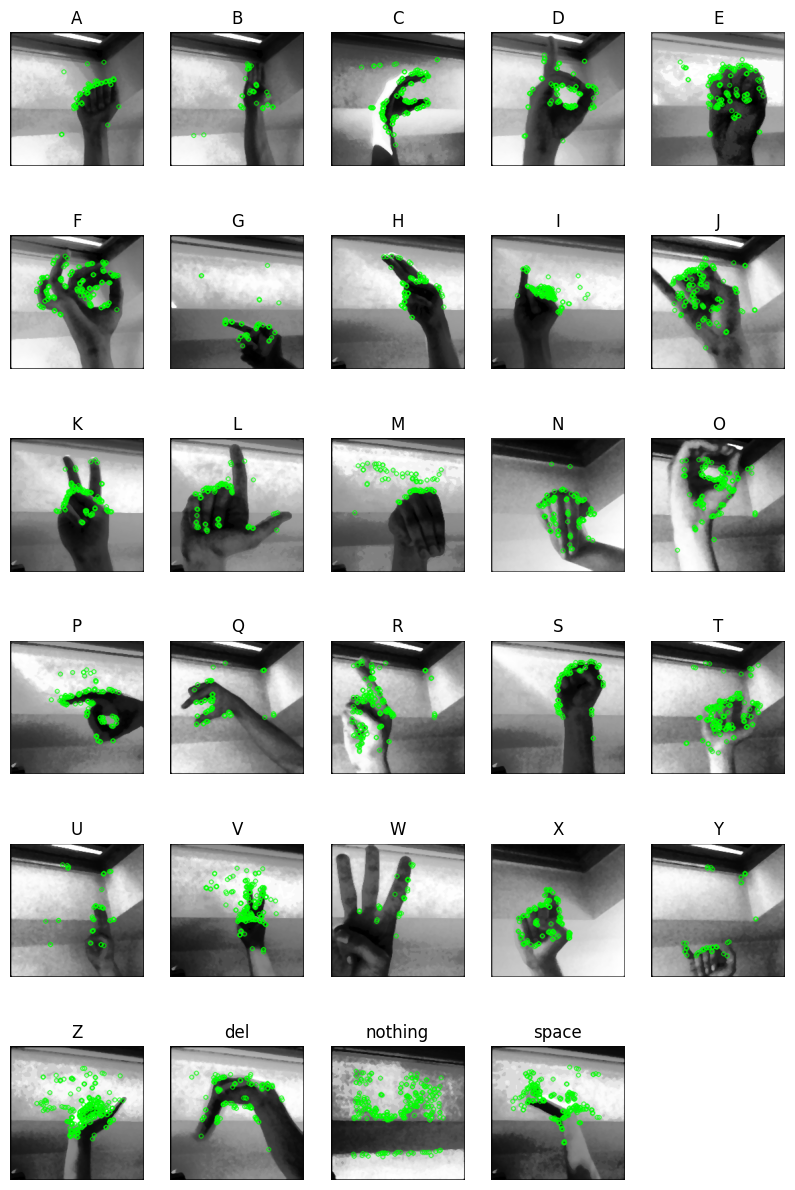

In [13]:
# Memvisualisasikan keypoint untuk setiap kelas
# Catatan: citra pada array dataset latih telah disortir menurut kelasnya

plt.figure(figsize=(10, 18))
for i in range(len(CLASSES)):
    ax = plt.subplot(7, 5, i+1)
    im = train_images_enhanced[(len(train_images_enhanced) // 29) * i] # Agar terambil citra pertama dari setiap kelas yang ada
    im = get_keypoint_vis_ORB(im)
    plt.imshow(im)
    plt.title(CLASSES[i])
    plt.axis('off')

In [14]:
# Menghapus data citra dari memori

del train_images_enhanced
del test_images_enhanced
gc.collect()

42

In [15]:
# Membuat bag of features dengan klasterisasi menggunakan KMeans
from sklearn.cluster import KMeans

# Ukuran word pada bag of features. Banyaknya klaster akan mengikuti nilai ini.
WORDS = 200

# Menggabungkan feature descriptor pada dataset latih dan dataset uji untuk diklasterisasi dengan KMeans dalam rangka menghasilkan bag of features. 
# Hal ini dapat dilakukan untuk mengurangi dimensi yang berlebih
kmeans = KMeans(n_clusters=WORDS, verbose=1).fit(np.concatenate([np.vstack(train_features), np.vstack(test_features)]))

Initialization complete
Iteration 0, inertia 1249229875989.0.
Iteration 1, inertia 965936294810.3159.
Iteration 2, inertia 945474620228.8878.
Iteration 3, inertia 937007643750.356.
Iteration 4, inertia 931993471076.8701.
Iteration 5, inertia 928566472614.752.
Iteration 6, inertia 926149871102.1028.
Iteration 7, inertia 924381072407.7639.
Iteration 8, inertia 923021074121.6735.
Iteration 9, inertia 921930122199.8274.
Iteration 10, inertia 921035623264.1427.
Iteration 11, inertia 920290342684.9529.
Iteration 12, inertia 919662321933.4109.
Iteration 13, inertia 919128511346.7251.
Iteration 14, inertia 918671866815.1162.
Iteration 15, inertia 918280651972.2605.
Iteration 16, inertia 917945423803.721.
Iteration 17, inertia 917654685103.6294.
Iteration 18, inertia 917398816432.8018.
Iteration 19, inertia 917172784373.9926.
Iteration 20, inertia 916971618122.2307.
Iteration 21, inertia 916791013805.512.
Iteration 22, inertia 916626914285.6057.
Iteration 23, inertia 916477232415.7715.
Iteratio

In [16]:
# Mendapatkan bag of features dari setiap citra
# Setiap fitur pada citra akan dikelompokkan ke dalam satu klaster, dengan model KMeans yang dilatih sebelumnya
# Selanjutnya, untuk setiap citra, banyaknya anggota masing-masing klaster akan dihitung
# Hal ini dilakukan untuk data latih dan data uji

X_train = np.stack([np.bincount(kmeans.predict(x), minlength=WORDS) for x in train_features])
X_test = np.stack([np.bincount(kmeans.predict(x), minlength=WORDS) for x in test_features])

In [17]:
# Menghapus data fitur dari memori
del train_features
del test_features
gc.collect()

0

## Klasifikasi dengan SVM

In [18]:
# Kita akan menggunakan ekstraksi fitur dan metode ML tradisional alih-alih menggunakan deep learning.

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [19]:
# Konversi data label menjadi NumPy Array

y_train = np.array(y_train)
y_test = np.array(y_test)

In [20]:
# Membuat dan melatih model-model SVM
# Terdapat tiga model SVM yang mengadaptasi kernel yang berbeda-beda

clf0 = SVC(kernel='rbf')
clf1 = SVC(kernel='poly')
clf2 = SVC(kernel='linear')

clf0.fit(X_train, y_train)
clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)

SVC(kernel='linear')

In [21]:
# Melakukan prediksi kelas untuk data uji

y_pred0 = clf0.predict(X_test)
y_pred1 = clf1.predict(X_test)
y_pred2 = clf2.predict(X_test)

In [22]:
# Menampilkan nilai akurasi model

print(f'Akurasi model 0 (rbf kernel): {accuracy_score(y_test, y_pred0)}')
print(f'Akurasi model 1 (poly kernel): {accuracy_score(y_test, y_pred1)}')
print(f'Akurasi model 2 (linear kernel): {accuracy_score(y_test, y_pred2)}')

Akurasi model 0 (rbf kernel): 0.8967816091954023
Akurasi model 1 (poly kernel): 0.7551149425287357
Akurasi model 2 (linear kernel): 0.6859770114942528


In [23]:
# Menampilkan laporan hasil klasifikasi

print('Classification report - Model 0 (rbf kernel):')
print(classification_report(y_test, y_pred0))

Classification report - Model 0 (rbf kernel):
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       600
           1       0.73      0.91      0.81       600
           2       0.92      0.94      0.93       600
           3       0.96      0.92      0.94       600
           4       0.90      0.88      0.89       600
           5       0.98      0.98      0.98       600
           6       0.88      0.90      0.89       600
           7       0.89      0.91      0.90       600
           8       0.91      0.90      0.91       600
           9       0.92      0.90      0.91       600
          10       0.94      0.92      0.93       600
          11       0.96      0.99      0.97       600
          12       0.88      0.89      0.88       600
          13       0.89      0.88      0.88       600
          14       0.91      0.92      0.91       600
          15       0.93      0.86      0.89       600
          16       0.95      0.90  

In [24]:
print('Classification report - Model 1 (poly kernel):')
print(classification_report(y_test, y_pred1))

Classification report - Model 1 (poly kernel):
              precision    recall  f1-score   support

           0       0.94      0.74      0.83       600
           1       0.62      0.67      0.64       600
           2       0.97      0.80      0.87       600
           3       0.94      0.85      0.89       600
           4       0.95      0.72      0.82       600
           5       0.82      0.87      0.85       600
           6       0.88      0.73      0.80       600
           7       0.94      0.79      0.86       600
           8       0.97      0.77      0.85       600
           9       0.97      0.73      0.83       600
          10       0.95      0.81      0.87       600
          11       0.89      0.91      0.90       600
          12       0.94      0.71      0.81       600
          13       0.89      0.75      0.81       600
          14       0.95      0.79      0.86       600
          15       0.94      0.68      0.79       600
          16       0.93      0.73 

In [25]:
print('Classification report - Model 2 (linear kernel):')
print(classification_report(y_test, y_pred2))

Classification report - Model 2 (linear kernel):
              precision    recall  f1-score   support

           0       0.61      0.72      0.66       600
           1       0.63      0.73      0.68       600
           2       0.78      0.85      0.81       600
           3       0.80      0.81      0.81       600
           4       0.62      0.67      0.64       600
           5       0.83      0.86      0.84       600
           6       0.72      0.78      0.75       600
           7       0.73      0.75      0.74       600
           8       0.69      0.71      0.70       600
           9       0.67      0.67      0.67       600
          10       0.74      0.77      0.75       600
          11       0.78      0.83      0.80       600
          12       0.55      0.57      0.56       600
          13       0.61      0.62      0.62       600
          14       0.73      0.71      0.72       600
          15       0.64      0.62      0.63       600
          16       0.66      0.6

<Axes: title={'center': 'Confusion Matrix - Model 0 (rbf kernel)'}>

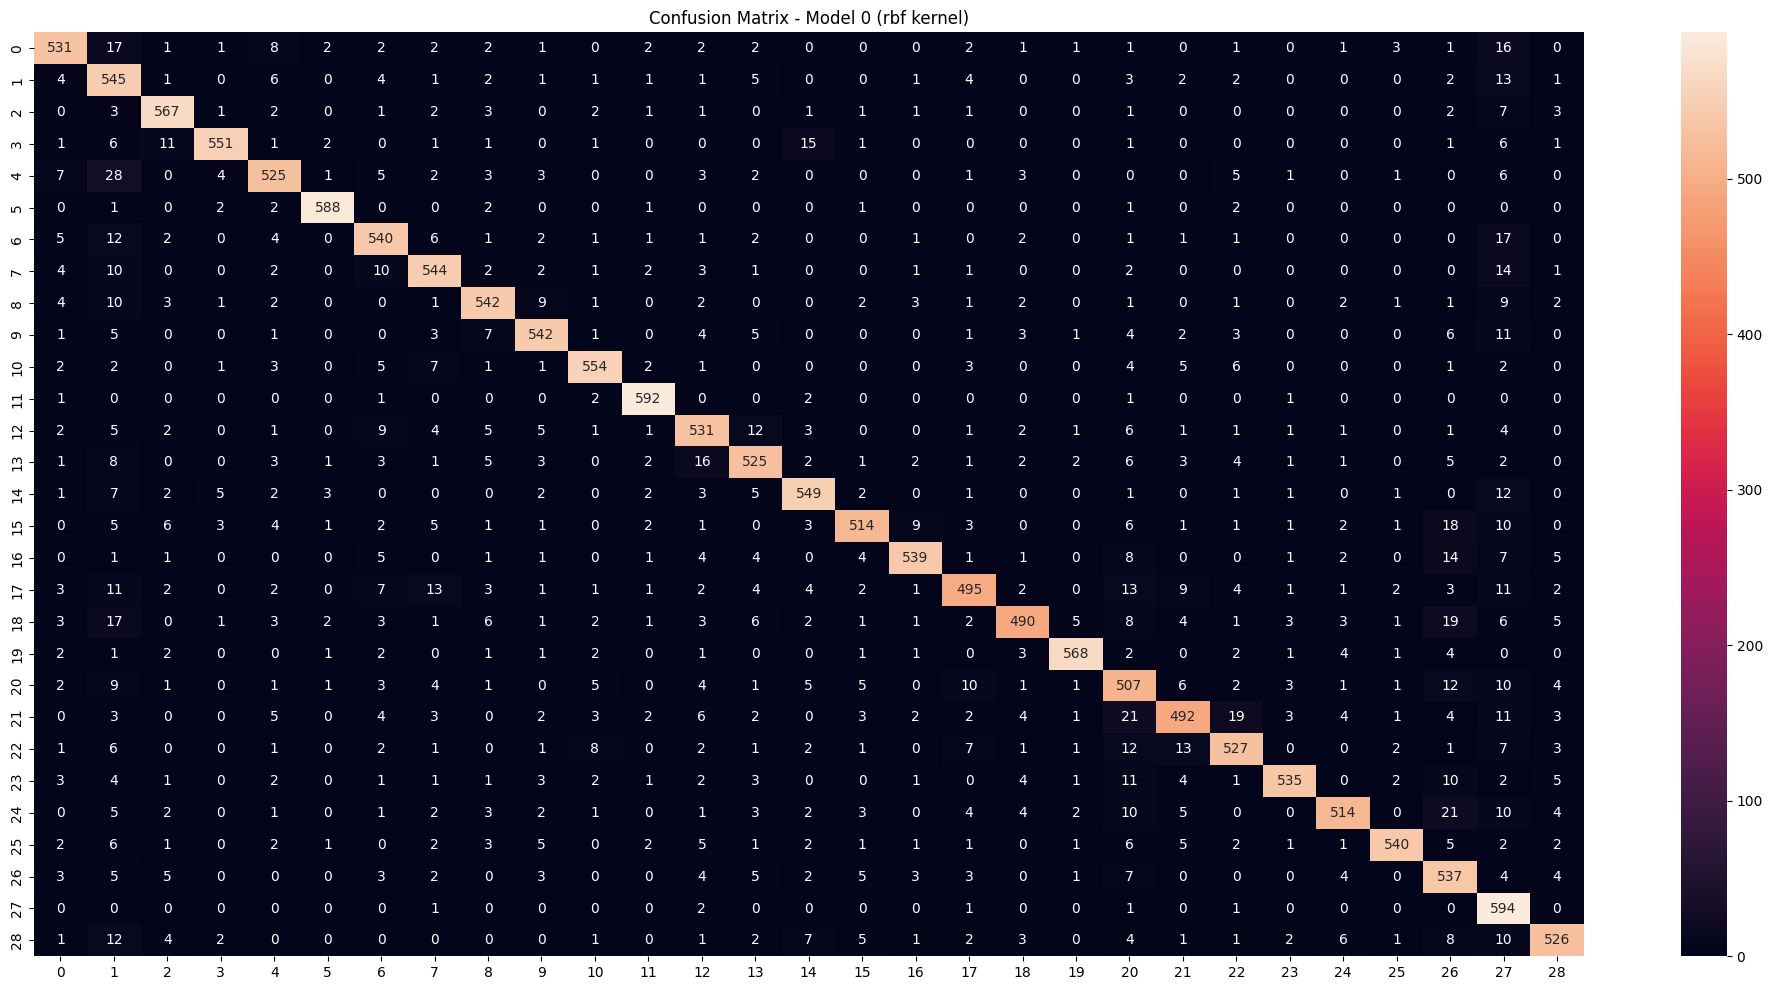

In [26]:
# Visualisasi Confusion Matrix

plt.figure(figsize=(25, 12))
plt.title('Confusion Matrix - Model 0 (rbf kernel)')
sns.heatmap(confusion_matrix(y_test, y_pred0), annot=True, fmt="d")

<Axes: title={'center': 'Confusion Matrix - Model 1 (poly kernel)'}>

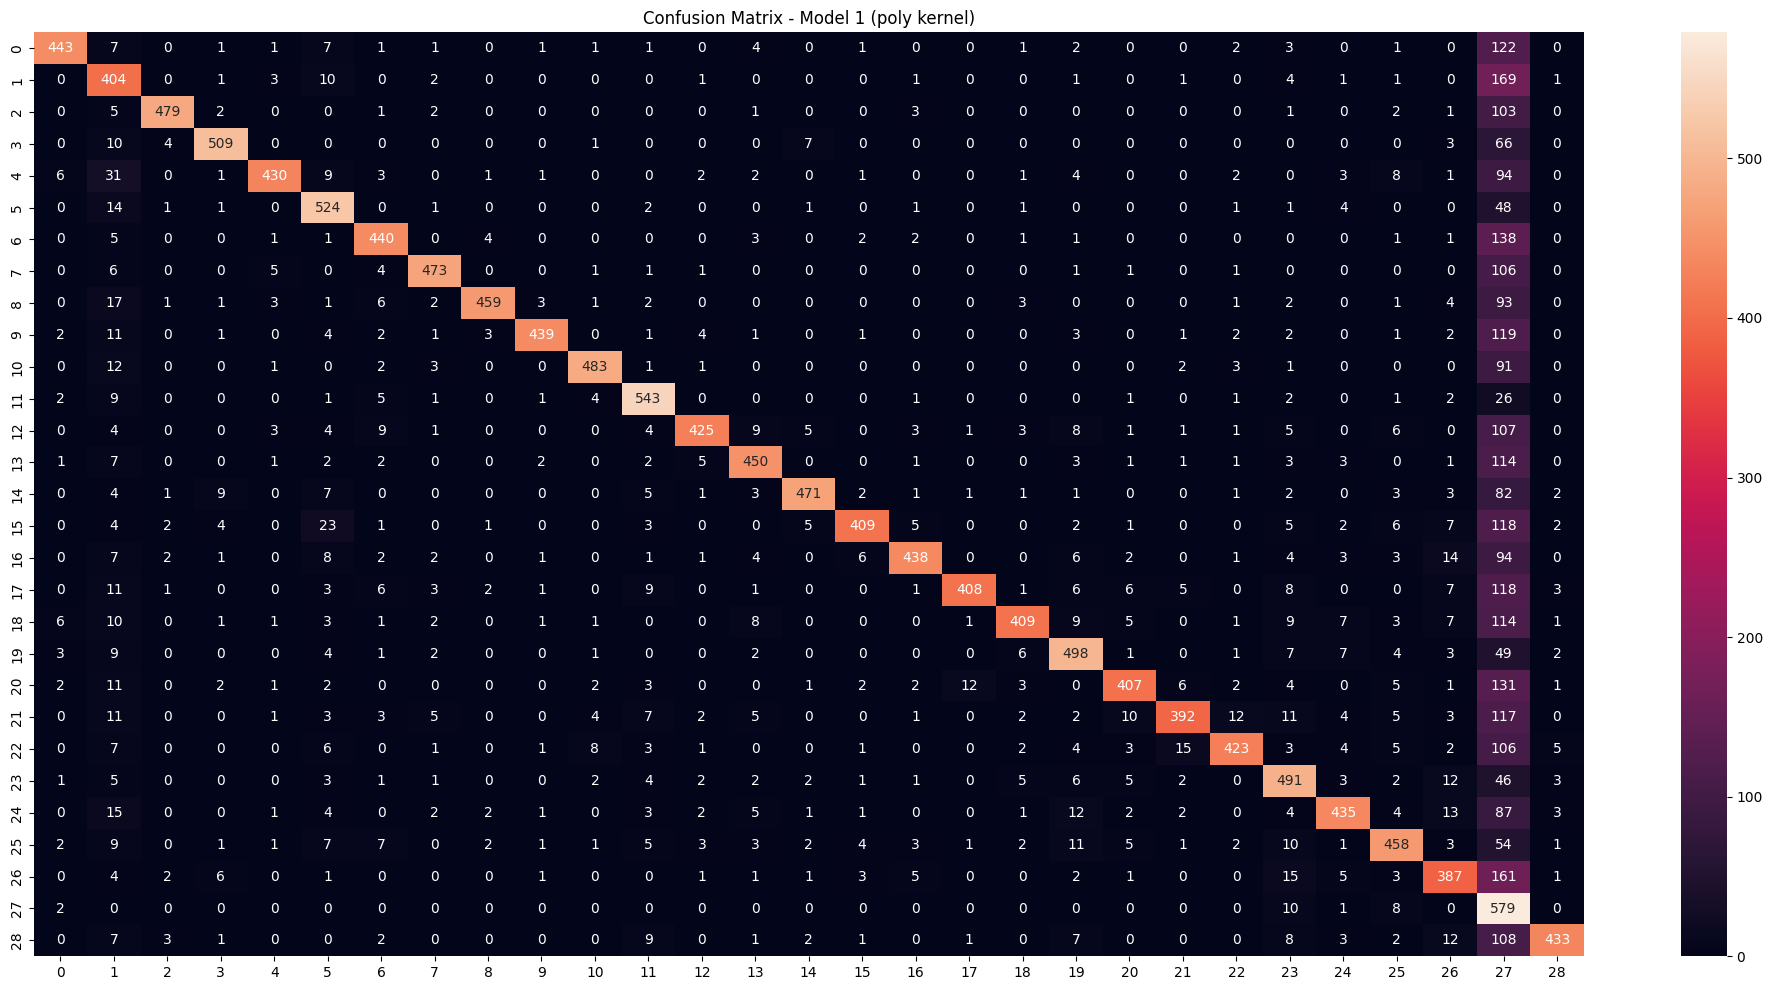

In [27]:
plt.figure(figsize=(25, 12))
plt.title('Confusion Matrix - Model 1 (poly kernel)')
sns.heatmap(confusion_matrix(y_test, y_pred1), annot=True, fmt="d")

<Axes: title={'center': 'Confusion Matrix - Model 2 (linear kernel)'}>

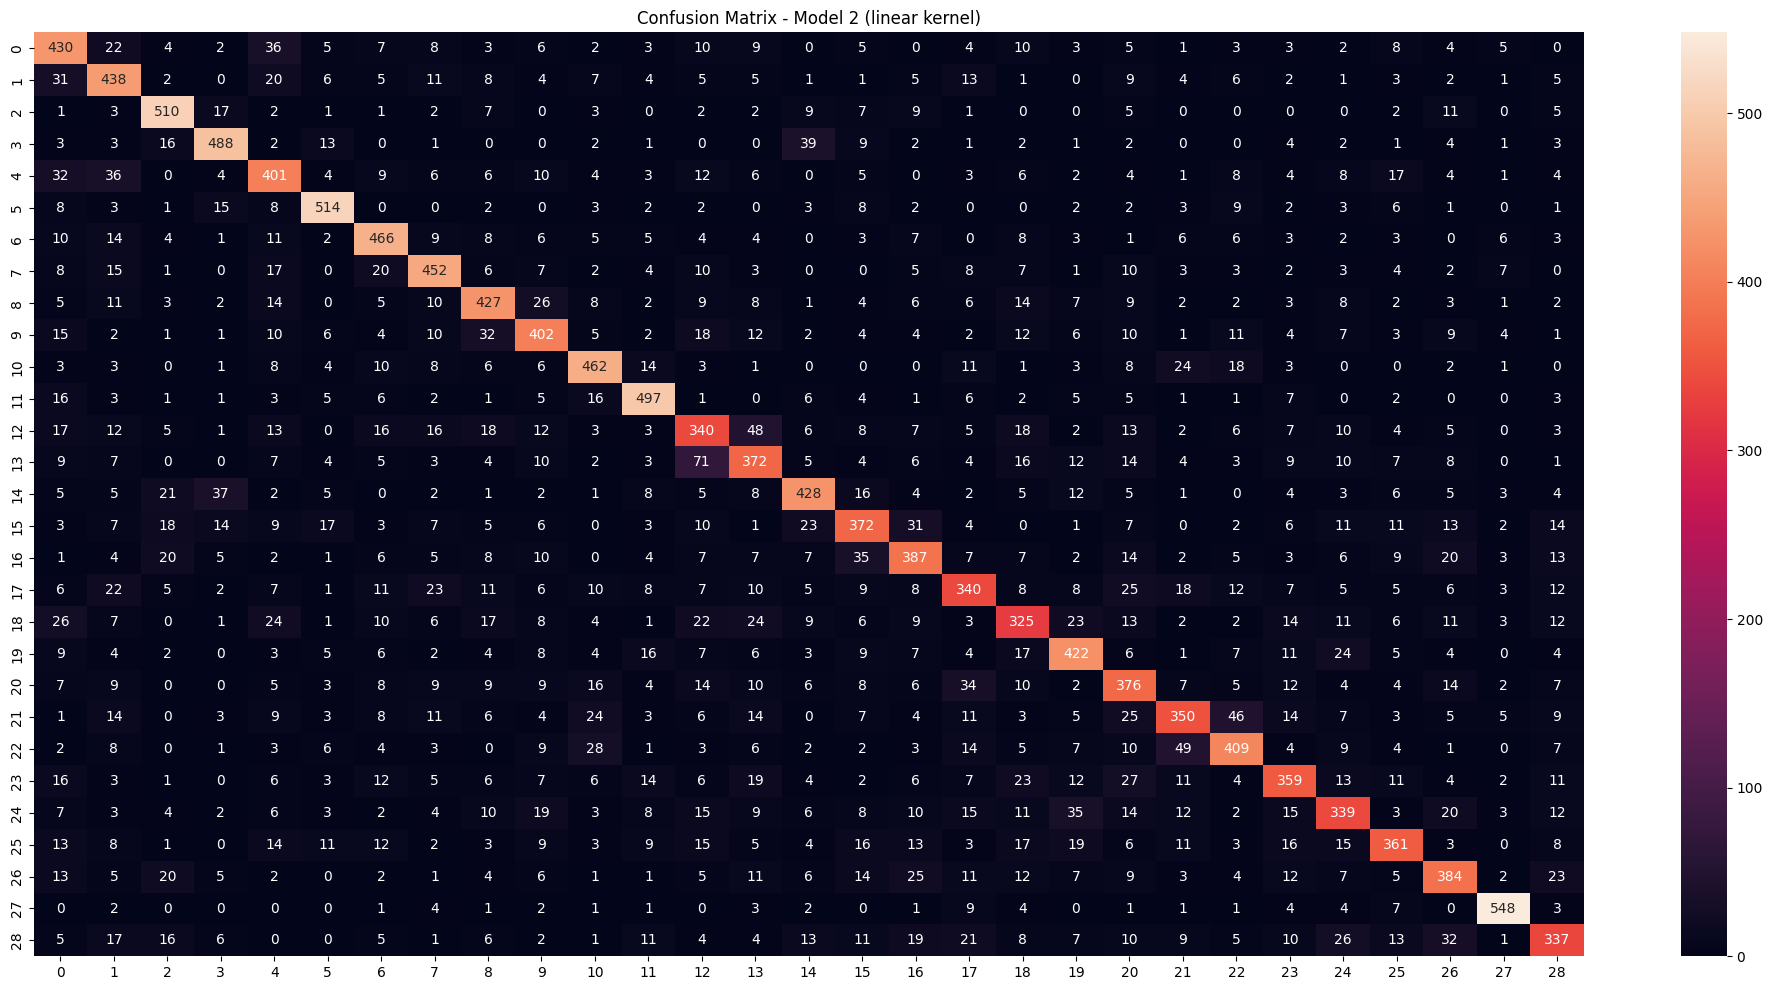

In [28]:
plt.figure(figsize=(25, 12))
plt.title('Confusion Matrix - Model 2 (linear kernel)')
sns.heatmap(confusion_matrix(y_test, y_pred2), annot=True, fmt="d")